# Part 1 Data Prepocess

In [1]:
from numpy import *
from sklearn.model_selection import cross_validate
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

## 1.1 Load dataset

In [2]:
# load the dataset 
data_train = pd.read_csv('train.csv', index_col=0)
data_test = pd.read_csv('test.csv', index_col=0)

# concat the training and testing dataset so that we can do preprocess 
# on both datasets simultaneously
data = pd.concat( [data_train, data_test], axis=0,sort=False )

## 1.2 Split names and encode the object as an enumerated type

In [3]:
# split 'Name'
## split ','
data.insert(1,'Title',data['Name']) 
data['Name'] = data['Name'].map(lambda x:x.split(',')[0])
data['Title'] = data['Title'].map(lambda x:x.split(',')[1])
## split'.
data.insert(1,'Last Name',data['Title']) 
data['Title'] = data['Title'].map(lambda x:x.split('.')[0])
data['Last Name'] = data['Last Name'].map(lambda x:x.split('.')[1])

# check missing values
print(data.isnull().sum())


Title = data.loc[:,'Title'].unique()
# Check the numbers for each title
counts = {}
for i in data.loc[:,'Title']:
    if i in counts:
        counts[i] +=1
    else:
        counts[i] = 1
print(counts)

# re-group to 5 main title:'Master','Miss','Mrs','Mr', 'DrAndRev'
data['Title'] = data['Title'].map(str.strip) 
data['Title'][data.Title == 'Jonkheer'] = 'Master'
data['Title'][data.Title.isin(['Ms','Mlle'])] = 'Miss'
data['Title'][data.Title.isin(['Mme','Dona', 'Lady', 'the Countess'])] = 'Mrs'
data['Title'][data.Title.isin(['Capt', 'Don', 'Major', 'Col', 'Sir'])] = 'Mr'
data['Title'][data.Title.isin(['Dr','Rev'])] = 'DrAndRev'


data.loc[:,'Title'].unique() # check again the unique values in Title
# Factorize title: 'Mr'=1, 'Mrs'=2, 'Miss'=3, 'Master'=4, 'DrAndRev'=5
title_trans = pd.factorize(data.Title) 
print(title_trans)
data['Title'] = pd.factorize(data.Title)[0]

Survived      418
Last Name       0
Title           0
Pclass          0
Name            0
Sex             0
Age           263
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin        1014
Embarked        2
dtype: int64
{' Mr': 757, ' Mrs': 197, ' Miss': 260, ' Master': 61, ' Don': 1, ' Rev': 8, ' Dr': 8, ' Mme': 1, ' Ms': 2, ' Major': 2, ' Lady': 1, ' Sir': 1, ' Mlle': 2, ' Col': 4, ' Capt': 1, ' the Countess': 1, ' Jonkheer': 1, ' Dona': 1}
(array([0, 1, 2, ..., 0, 0, 3], dtype=int64), Index(['Mr', 'Mrs', 'Miss', 'Master', 'DrAndRev'], dtype='object'))


C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

## 1.3 Refill missing values in Embarked and create dummy varibale

In [4]:
# refill 2 missing values for 'Embarked'
Embarked_missing = data[data.loc[:,'Embarked'].isnull()] # get the rows with missing values

# Looking at 'Ticket','Survived','Pclass', we find out that these two rows are more similar 
# to the rows with Embarked S than other rows.
data.loc[data.loc[:,'Embarked'].isnull(),'Embarked'] = 'S'

In [5]:
# create dummy variables
dummies = pd.get_dummies(data.loc[:,'Embarked'], prefix = 'Embarked')
data = pd.concat([data,dummies],axis = 1)

# check missing values again
print(data.isnull().sum())

Survived       418
Last Name        0
Title            0
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin         1014
Embarked         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
dtype: int64


## 1.4 Refill missing values in Fare

In [6]:
# refill 1 missing values for 'Fare'
Fare_missing = data[data.loc[:,'Fare'].isnull()] # get the rows with missing values

# We fill in the missing value with the mean of fares with Class 3 and Embarked S
C3_ES_fare = data[(data['Pclass']==3) & (data['Embarked']=='S')].loc[:,'Fare']
C3_ES_fare_mean = round(C3_ES_fare.mean(),2)
data.loc[data.loc[:,'Fare'].isnull(),'Fare'] = C3_ES_fare_mean

# check missing values again
print(data.isnull().sum())

Survived       418
Last Name        0
Title            0
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin         1014
Embarked         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
dtype: int64


## 1.5 Refill missing values in Age

In [7]:
# refill 263 missing values for 'Age'
# split the data into two part: known_age and unknown_age
age_data = data.loc[:,['Age','Parch','SibSp','Pclass','Title']]
known_age = age_data[age_data.Age.notnull()].as_matrix()
unknown_age = age_data[age_data.Age.isnull()].as_matrix()
y_knownage = known_age[:,0]
X_knownage = known_age[:,1:]

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [8]:
# fit the RandomForestRegressor model
rfr = RandomForestRegressor(random_state=0, n_estimators=200, n_jobs=-1)
rfr.fit(X_knownage, y_knownage)

# predict the unknown age
predictedAges = rfr.predict(unknown_age[:, 1:])

# refill the missing values
data.loc[data.loc[:,'Age'].isnull(),'Age'] = predictedAges

In [9]:
# Categorize ages
# 0 for teenager (0-18), 1 for adult(19-50), 2 for elder(51-)
Age_cat = []
for i in data.loc[:,'Age']:
    if int(i) <= 18:
        Age_cat.append(0)
    elif int(i) >18 and int(i) <= 50:
        Age_cat.append(1)
    else:
        Age_cat.append(2)
data['Age_cat'] = Age_cat
data.head(5)

,Survived,Last Name,Title,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Age_cat
PassengerId,,,,,,,,,,,,,,,,,
1,0.0,Owen Harris,0,3,Braund,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,1
2,1.0,John Bradley (Florence Briggs Thayer),1,1,Cumings,female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1
3,1.0,Laina,2,3,Heikkinen,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1
4,1.0,Jacques Heath (Lily May Peel),1,1,Futrelle,female,35.0,1,0,113803,53.1000,C123,S,0,0,1,1
5,0.0,William Henry,0,3,Allen,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,1


In [10]:
# check missing values again
print(data.isnull().sum())

Survived       418
Last Name        0
Title            0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin         1014
Embarked         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Age_cat          0
dtype: int64


## 1.6 Factorize values in Sex (male = 0, female = 1)

In [11]:
# check again the unique values in sex
data.loc[:,'Sex'].unique() 
# factorize values in Sex: 'Male'=0, 'Female'=1
Sex_trans = pd.factorize(data.Sex) 
print(Sex_trans)
data['Sex'] = pd.factorize(data.Sex)[0]
data.head(5)

(array([0, 1, 1, ..., 0, 0, 0], dtype=int64), Index(['male', 'female'], dtype='object'))


,Survived,Last Name,Title,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Age_cat
PassengerId,,,,,,,,,,,,,,,,,
1,0.0,Owen Harris,0,3,Braund,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,1
2,1.0,John Bradley (Florence Briggs Thayer),1,1,Cumings,1,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1
3,1.0,Laina,2,3,Heikkinen,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1
4,1.0,Jacques Heath (Lily May Peel),1,1,Futrelle,1,35.0,1,0,113803,53.1000,C123,S,0,0,1,1
5,0.0,William Henry,0,3,Allen,0,35.0,0,0,373450,8.0500,NaN,S,0,0,1,1


## Categorize Fare

In [12]:
# Categorize Fare
max_fare = data.Fare.max()
min_fare = data.Fare.min()
range_fare = max_fare - min_fare

#1 for fare 0-10, 2 for fare 10-100, 3 for fare 100 and more
fare_cat = []
for i in data.loc[:,'Fare']:
    if i <= 10:
        fare_cat.append(1)
    elif i >10 and i <= 100:
        fare_cat.append(2)
    else:
        fare_cat.append(3)

data['Fare'] = fare_cat

## 1.7 Generate new feature 'FamilySize'

In [13]:
# Create new features called number of companions
data['FamilySize'] = data['SibSp'] + data['Parch']
data.head(5)

,Survived,Last Name,Title,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Age_cat,FamilySize
PassengerId,,,,,,,,,,,,,,,,,,
1,0.0,Owen Harris,0,3,Braund,0,22.0,1,0,A/5 21171,1,NaN,S,0,0,1,1,1
2,1.0,John Bradley (Florence Briggs Thayer),1,1,Cumings,1,38.0,1,0,PC 17599,2,C85,C,1,0,0,1,1
3,1.0,Laina,2,3,Heikkinen,1,26.0,0,0,STON/O2. 3101282,1,NaN,S,0,0,1,1,0
4,1.0,Jacques Heath (Lily May Peel),1,1,Futrelle,1,35.0,1,0,113803,2,C123,S,0,0,1,1,1
5,0.0,William Henry,0,3,Allen,0,35.0,0,0,373450,1,NaN,S,0,0,1,1,0


## 1.8 Generate new feature 'Companions '

In [14]:
Ticket = data.loc[:,'Ticket'].unique()
# Check the numbers for each ticket number
counts_ticket = {}
for i in data.loc[:,'Ticket']:
    if i in counts_ticket:
        counts_ticket[i] +=1
    else:
        counts_ticket[i] = 1
        
# Find the number of companions for each passengers
Companions = []
for i in data.loc[:,'Ticket']:
    if i in counts_ticket:
        Companions.append(counts_ticket[i])
# Add the new feature 'Companions' to the dataset
data['Companions'] = Companions

# Regrouping all person accompanied by more than 2 people
# So that 1='alone', 2='1companions', 3='2 or more companions'
for i in range(data.shape[0]):
    if data.iloc[i,18] >= 3:
        data.iloc[i,18] = 3
        


data 

,Survived,Last Name,Title,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Age_cat,FamilySize,Companions
PassengerId,,,,,,,,,,,,,,,,,,,
1,0.0,Owen Harris,0,3,Braund,0,22.000000,1,0,A/5 21171,1,NaN,S,0,0,1,1,1,1
2,1.0,John Bradley (Florence Briggs Thayer),1,1,Cumings,1,38.000000,1,0,PC 17599,2,C85,C,1,0,0,1,1,2
3,1.0,Laina,2,3,Heikkinen,1,26.000000,0,0,STON/O2. 3101282,1,NaN,S,0,0,1,1,0,1
4,1.0,Jacques Heath (Lily May Peel),1,1,Futrelle,1,35.000000,1,0,113803,2,C123,S,0,0,1,1,1,2
5,0.0,William Henry,0,3,Allen,0,35.000000,0,0,373450,1,NaN,S,0,0,1,1,0,1
6,0.0,James,0,3,Moran,0,28.484979,0,0,330877,1,NaN,Q,0,1,0,1,0,1
7,0.0,Timothy J,0,1,McCarthy,0,54.000000,0,0,17463,2,E46,S,0,0,1,2,0,2
8,0.0,Gosta Leonard,3,3,Palsson,0,2.000000,3,1,349909,2,NaN,S,0,0,1,0,4,3
9,1.0,Oscar W (Elisabeth Vilhelmina Berg),1,3,Johnson,1,27.000000,0,2,347742,2,NaN,S,0,0,1,1,2,3


## 1.9 Remove columns and create training and testing dataset

In [15]:
# remove 'Cabin', 'Ticket','Name','Last Name'
data_drop = data.drop(['Ticket','Name','Last Name','Embarked','Embarked_Q','SibSp','Parch','Age','Cabin'],axis=1)
data_drop.head(5)

,Survived,Title,Pclass,Sex,Fare,Embarked_C,Embarked_S,Age_cat,FamilySize,Companions
PassengerId,,,,,,,,,,
1,0.0,0,3,0,1,0,1,1,1,1
2,1.0,1,1,1,2,1,0,1,1,2
3,1.0,2,3,1,1,0,1,1,0,1
4,1.0,1,1,1,2,0,1,1,1,2
5,0.0,0,3,0,1,0,1,1,0,1


In [16]:
#create training and testing dataset
train_X = data_drop.iloc[0:891,1:10]
train_y = data_drop.iloc[0:891,0]
test_X = data_drop.iloc[891:,1:10]
train_X.head(5)

,Title,Pclass,Sex,Fare,Embarked_C,Embarked_S,Age_cat,FamilySize,Companions
PassengerId,,,,,,,,,
1,0,3,0,1,0,1,1,1,1
2,1,1,1,2,1,0,1,1,2
3,2,3,1,1,0,1,1,0,1
4,1,1,1,2,0,1,1,1,2
5,0,3,0,1,0,1,1,0,1


# Part 2 Feature Learning

In [17]:
# Draw heatmap to learn about the correlation among all the features and class labels
corr_list = data_drop.iloc[0:891,0:10]
corr = ['Survived','Title','Pclass','Sex','Fare','Embarked_C','Embarked_S','Age_cat','FamilySize','Companions']
corr_matrix = corr_list[corr].corr()

# fig = plt.figure(figsize=(13,13))
# cmap = sns.diverging_palette(220,10,as_cmap=True)
# ax = sns.heatmap(corr_matrix, cmap=cmap, vmax=1,center = 0.5, square=True,linewidths=.5,annot = True)
# ax.set_title('Correlation matrix',fontsize=20)
# plt.yticks(rotation=0)
# plt.show()

corr_list

,Survived,Title,Pclass,Sex,Fare,Embarked_C,Embarked_S,Age_cat,FamilySize,Companions
PassengerId,,,,,,,,,,
1,0.0,0,3,0,1,0,1,1,1,1
2,1.0,1,1,1,2,1,0,1,1,2
3,1.0,2,3,1,1,0,1,1,0,1
4,1.0,1,1,1,2,0,1,1,1,2
5,0.0,0,3,0,1,0,1,1,0,1
6,0.0,0,3,0,1,0,0,1,0,1
7,0.0,0,1,0,2,0,1,2,0,2
8,0.0,3,3,0,2,0,1,0,4,3
9,1.0,1,3,1,2,0,1,1,2,3


Since 'Sex', 'Title', 'Pclass', 'Fare', 'Companions' have relatively high correlation with Survived, we decide to take a look at their distribution.

### Sex

C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Julien\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


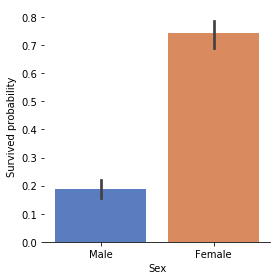

In [18]:
# Explore Sex vs Survived
g = sns.factorplot(x='Sex', y='Survived', data = corr_list, kind='bar',size = 4, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survived probability')
g.set_xticklabels(('Male', 'Female'))

### Title

C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


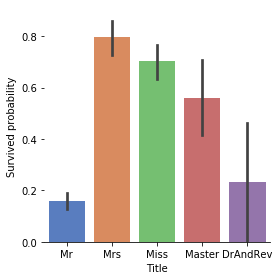

In [19]:
# Explore Title vs Survived
g = sns.factorplot(x='Title', y='Survived', data = corr_list, kind='bar',size = 4, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survived probability')
g.set_xticklabels(('Mr', 'Mrs', 'Miss', 'Master', 'DrAndRev'))

### Pclass

C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


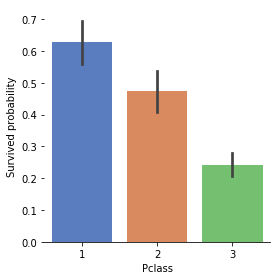

In [20]:
# Explore Pclass vs Survived
g = sns.factorplot(x='Pclass', y='Survived', data = corr_list, kind='bar',size = 4, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survived probability')

### Fare

C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


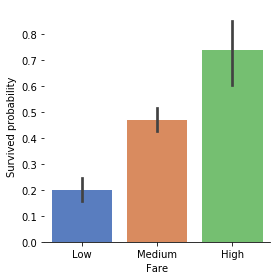

In [21]:
# Explore Fare vs Survived
g = sns.factorplot(x='Fare', y='Survived', data = corr_list, kind='bar',size = 4, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survived probability')
g.set_xticklabels(('Low', 'Medium','High'))

### Companions

C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Julien\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


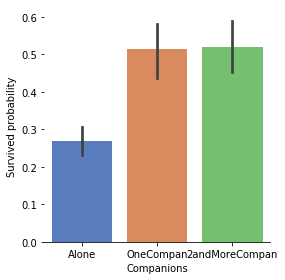

In [22]:
# Explore Companions vs Survived
g = sns.factorplot(x='Companions', y='Survived', data = corr_list, kind='bar',size = 4, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survived probability')
g.set_xticklabels(('Alone', 'OneCompan','2andMoreCompan'))

# Part 3  Model Training

In [23]:
# First define a function to generate csv file 
def predict_csv(predic_y, model_name):
    PassengerId = pd.Series(range(892,1310))
    test_survived = pd.concat([PassengerId, pd.Series(predic_y)],axis =1)
    test_survived.columns = ['PassengerId','Survived']
    test_survived.to_csv('predicted_class_%s.csv'% model_name, index= False)

## 3.1 Desicion tree

In [24]:
# Data standardization and transformation 
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(train_X)
train_X_transformed = scaler.transform(train_X)
test_X_transformed = scaler.transform(test_X)

C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """
C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Testing the model in the training phase
cv_DS = StratifiedKFold(n_splits =10)
clf_DS = DecisionTreeClassifier()
scores_DS = cross_val_score(clf_DS, train_X, train_y, cv=cv_DS)
accu_dt = scores_DS.mean()
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_DS.mean(),scores_DS.std()*2))

# Train the model using the whole training dataset
clf_DS = DecisionTreeClassifier().fit(train_X, train_y)

# Predict the labels in test_X
y_pred_dt = clf_DS.predict(test_X).astype(int)

# stroe it in the csv file
predict_csv(y_pred_dt, 'DT')

Accuracy: 0.80 (+/- 0.07)


## 3.2 Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

clf_rf = RandomForestClassifier(bootstrap = True, max_depth = 5)
kf = KFold(10)
kf.get_n_splits(train_X)
outcomes = []
fold = 0

for train_index, test_index in kf.split(train_X):
    fold +=1
    X_train, X_test = train_X.values[train_index], train_X.values[test_index]
    y_train, y_test = train_y.values[train_index], train_y.values[test_index]
    
    clf_rf.fit(X_train, y_train)
    predictions = clf_rf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    outcomes.append(accuracy)
    print('Fold {0} accuracy: {1}'.format(fold,round(accuracy,3)))
    
accu_rf = mean(outcomes)
print('Mean Accuracy: {0}'.format(round(accu_rf,3)))

y_pred_rf = clf_rf.predict(test_X).astype(int)

# store it in the csv file
predict_csv(y_pred_rf,'rf')

Fold 1 accuracy: 0.822
Fold 2 accuracy: 0.876
Fold 3 accuracy: 0.775
Fold 4 accuracy: 0.888
Fold 5 accuracy: 0.843
Fold 6 accuracy: 0.843
Fold 7 accuracy: 0.798
Fold 8 accuracy: 0.775
Fold 9 accuracy: 0.865
Fold 10 accuracy: 0.843
Mean Accuracy: 0.833


C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## 3.3 Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Testing the model in the training phase
cv_LR = StratifiedKFold(n_splits =10)
logreg = LogisticRegression()
scores_LR = cross_val_score(logreg, train_X, train_y, cv=cv_LR)
print(scores_LR)
print(mean(scores_LR))
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_LR.mean(),scores_LR.std()*2))

x_train, x_val, y_train, y_val = train_test_split(train_X, train_y, test_size = 0.22, random_state = 0)


# Fit the classifier to the training data
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
accu_logreg = scores_LR.mean()
print(accu_logreg)

C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.82222222 0.78888889 0.75280899 0.87640449 0.78651685 0.75280899
 0.80898876 0.82022472 0.80898876 0.79545455]
0.8013307229599365
Accuracy: 0.80 (+/- 0.07)
0.8013307229599365


C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Julien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [28]:
# Predict the labels of the test set: y_pred
y_pred_logicRe = logreg.predict(test_X).astype(int)

# stroe it in the csv file
predict_csv(y_pred_logicRe,'LogicRe')

## 3.4 KNN

0.7991021324354658
Accuracy: 0.04 (+/- 0.33)
0.8181818181818182
Accuracy: 0.08 (+/- 0.47)
0.8148148148148148
Accuracy: 0.12 (+/- 0.56)
0.8473625140291807
Accuracy: 0.16 (+/- 0.64)
0.8181818181818182
Accuracy: 0.21 (+/- 0.69)
0.8451178451178452
Accuracy: 0.25 (+/- 0.73)
0.8372615039281706
Accuracy: 0.29 (+/- 0.77)
0.8406285072951739
Accuracy: 0.34 (+/- 0.79)
0.8395061728395061
Accuracy: 0.38 (+/- 0.80)
0.8305274971941639
Accuracy: 0.42 (+/- 0.80)
0.8372615039281706
Accuracy: 0.47 (+/- 0.80)
0.8372615039281706
Accuracy: 0.51 (+/- 0.78)
0.8428731762065096
Accuracy: 0.55 (+/- 0.75)
0.8327721661054994
Accuracy: 0.59 (+/- 0.71)
0.8305274971941639
Accuracy: 0.64 (+/- 0.66)
0.8305274971941639
Accuracy: 0.68 (+/- 0.59)
0.8338945005611672
Accuracy: 0.72 (+/- 0.50)
0.8327721661054994
Accuracy: 0.77 (+/- 0.36)
0.8327721661054994
Accuracy: 0.81 (+/- 0.04)
The optimal number of neighbors is 7


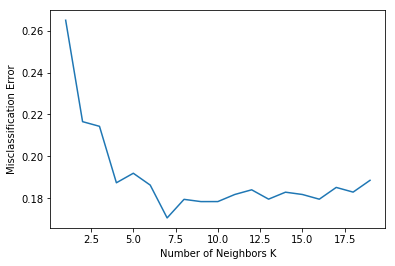

In [29]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV

#Setup arrays to store train and test accuracies
neighbors = np.arange(1,20)
train_accuracy = np.empty(len(neighbors))
scores_knn = np.empty(len(neighbors))
cv_knn = StratifiedKFold(n_splits =10)
#Loop over different values of k to find best value of k
for i, k in enumerate(neighbors):
    #Setup a k-nn Classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors = k)
    
    #Fit the classifier to the training data
    knn.fit(train_X, train_y)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(train_X, train_y)
    print(train_accuracy[i])
    scores_knn[i]= mean(cross_val_score(knn, train_X, train_y, cv=cv_knn, scoring = "accuracy"))
    print('Accuracy: %0.2f (+/- %0.2f)' % (scores_knn.mean(),scores_knn.std()*2))

    
    
MSE = [1 - x for x in scores_knn]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

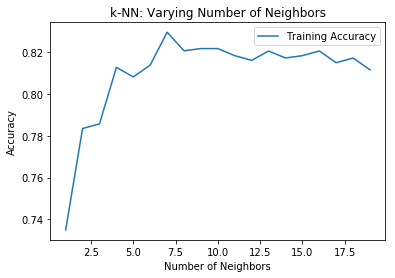

In [30]:
# Generate plot to visualize best value of k
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, scores_knn, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()   


In [31]:
#Verification number 95684520... because not sure about optimal number of k
#Verification using GridSearchCV

from sklearn.model_selection import GridSearchCV
param_grid = {"n_neighbors":np.arange(1,20)}
knn = KNeighborsClassifier()
cv_knn = StratifiedKFold(n_splits =10)
knn_cv = GridSearchCV(knn, param_grid, cv = cv_knn)
knn_cv.fit(train_X, train_y)
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 7}
0.8294051627384961


In [32]:
# Create a k-NN classifier with 7 neighbors: knn
knn = KNeighborsClassifier(n_neighbors = 7)

# Testing the model in the training phase
cv_knn = StratifiedKFold(n_splits =10)
scores_knn = cross_val_score(knn, train_X, train_y, cv=cv_knn)
accu_knn = scores_knn.mean()
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_knn.mean(),scores_knn.std()*2))

print(scores_knn)
print(mean(scores_knn))
# Fit the classifier to the data
knn.fit(train_X,train_y)

# Predict the labels for the testing data x_val
y_pred_knn = knn.predict(test_X).astype(int)

# store it in the csv file
predict_csv(y_pred_knn,'knn')

Accuracy: 0.83 (+/- 0.07)
[0.8        0.85555556 0.76404494 0.84269663 0.85393258 0.83146067
 0.86516854 0.78651685 0.88764045 0.80681818]
0.829383441153104


## 3.5 Adaboost

In [33]:
#Boosting
from sklearn.ensemble import AdaBoostClassifier #For Classification
from sklearn.ensemble import AdaBoostRegressor #For Regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

DTC = DecisionTreeClassifier()

adaB = AdaBoostClassifier(DTC, random_state=7)

cv_ada = StratifiedKFold(n_splits =10)

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}


adaBoost = GridSearchCV(adaB,param_grid = param_grid, cv=cv_ada, scoring="accuracy", n_jobs= 4, verbose = 1)

adaBoost.fit(train_X,train_y)

best_adaB = adaBoost.best_estimator_

adaBoost.best_score_

accu_ada = adaBoost.best_score_

y_pred_ada = best_adaB.predict(test_X).astype(int)

# store it in the csv file
predict_csv(y_pred_ada, 'adatest')

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 410 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    3.3s finished


In [34]:
adaBoost.best_score_

0.8024691358024691

## 3.6 SVC

In [35]:
from sklearn.svm import SVC

cv_svc = StratifiedKFold(n_splits =10)
clf_svc = SVC(C = 1, kernel = 'linear')
scores_svc = cross_val_score(clf_svc, train_X, train_y, cv=cv_svc)
accu_svc = scores_svc.mean()

# train the model using the whole training dataset
clf_svc.fit(train_X,train_y)
# predict the labels of test dataset
y_pred_svc =clf_svc.predict(test_X).astype(int)

# store it in the csv file
predict_csv(y_pred_svc, 'svc')

# Part 4 Model Selection and Label Prediction

## 4.1 Model comparison and selection

In [36]:
# first we integrate the accuracy of different models
model_name = pd.Series(['DecisionTree', 'RandomForest', 'LogisticRegression', 'KNN', 'Adaboost','SVC'])
accu_train = pd.Series([accu_dt, accu_rf, accu_logreg, accu_knn, accu_ada, accu_svc])
score_kaggle = pd.Series([0.78947,0.77990,0.77033,0.67942,0.79425,0.76555])
Model_performance = pd.concat([model_name, accu_train, score_kaggle],axis =1)
Model_performance.columns = ['Model', 'TrainAccuracy', 'ScoreKaggle']
Model_performance.sort_values(by='ScoreKaggle', ascending = False)

,Model,TrainAccuracy,ScoreKaggle
4,Adaboost,0.802469,0.79425
0,DecisionTree,0.796887,0.78947
1,RandomForest,0.832784,0.77990
2,LogisticRegression,0.801331,0.77033
5,SVC,0.785575,0.76555
3,KNN,0.829383,0.67942


RandomForest has the highest training accuracy, while Adaboost gains the best score on Kaggle. Therefore, we will take a look at the feature importance on both models.

## 4.2 Feature importance in RamdomForest

In [37]:
# Get feature importance for each feature using Logistic Regression
feature_rf = pd.Series(clf_rf.feature_importances_)
feature_name= pd.Series(train_X.columns.values.tolist())
Feature_imp_rf = pd.concat([feature_name,feature_rf],axis =1)
Feature_imp_rf.columns = ['Feature', 'ImportanceScore']
Feature_imp_rf = Feature_imp_rf.sort_values(by='ImportanceScore', ascending = False)

Text(0.5, 1.0, 'RandomForest Feature Importance')

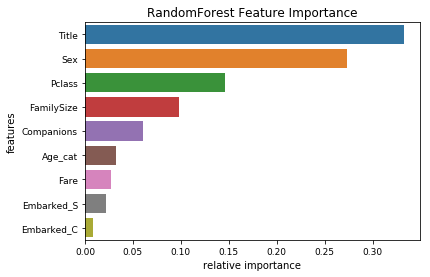

In [38]:
# plot feature importance
g = sns.barplot(y = Feature_imp_rf.loc[:,'Feature'], x = Feature_imp_rf.loc[:,'ImportanceScore'], orient='h')
g.set_xlabel('relative importance')
g.set_ylabel('features')
g.tick_params(labelsize=9)
g.set_title('RandomForest Feature Importance' )

## 4.3 Feature importance in Adaboost

In [39]:
# Get feature importance for each feature using Logistic Regression
feature_ada = pd.Series(best_adaB.feature_importances_)
Feature_imp_ada = pd.concat([feature_name,feature_ada],axis =1)
Feature_imp_ada.columns = ['Feature', 'ImportanceScore']
Feature_imp_ada = Feature_imp_ada.sort_values(by='ImportanceScore', ascending = False)

Text(0.5, 1.0, 'AdaBoost Feature Importance')

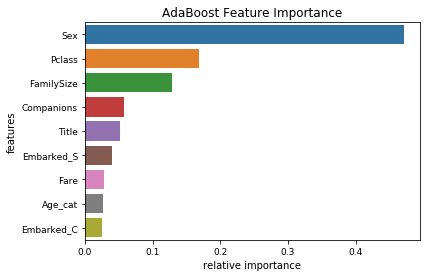

In [40]:
# plot feature importance
g = sns.barplot(y = Feature_imp_ada.loc[:,'Feature'], x = Feature_imp_ada.loc[:,'ImportanceScore'], orient='h')
g.set_xlabel('relative importance')
g.set_ylabel('features')
g.tick_params(labelsize=9)
g.set_title('AdaBoost Feature Importance' )

## 4.4 Use Voting Classifier to Combine Models
Since RandomForest gets the highest training accuracy among all models and Adaboost gets the highest score on Kaggle, we decide to use Voting classifier to integrate these two models.

In [41]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[('rf', clf_rf), ('adaboost', best_adaB)], voting='soft', n_jobs=4)

votingC = votingC.fit(train_X, train_y)

# Predict the labels in test_X
y_pred_vot = votingC.predict(test_X).astype(int)

# stroe it in the csv file
predict_csv(y_pred_vot, 'Vot')